# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic
groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json

# lets add import files which we need 
import matplotlib.pyplot as plt
import seaborn as sns
!pip install progressbar
import progressbar
from datetime import datetime
from collections import defaultdict
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.externals import joblib
from sklearn.metrics import roc_auc_score, recall_score,r2_score, f1_score

% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Project Business Analysis

Almost every individual if this century has a favorite Starbucks drink. As stated in the description above, the data used for this project is a small portion of data collected from Starbuks application. this project we will tackle our data to answer the following business problems.
1. Find a corelations between a customer and an offer?
2. How to suggest the most suitable offer based on a customer?
3. Does the customer open an offer before reaching offer condition? or they reach condition without seeing an offer?
4. How about considering a loyality offer?
5. Transaction-wise, what is the average of transactions per customers?

The following notebook will take you on a Data-Journey starting from exporing the data to evaluating the models and analysing results. 
lets start~

## A journey starts with exporing 
The first step, is exporing our data set
lets start by viewing the portfolio and investigating the rows and columns of our data. we also use visulization to help us get a better understanding of our data.

In [2]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
portfolio.shape

(10, 6)

In [4]:
# ok our portfolio data is looking good lets check out the profile data next 
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [5]:
profile.shape

(17000, 5)

In [6]:
# I see some NaNs, lets see how many are there so we can scrub them off
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

We can see that our columns gender and income have the NaNs in them.. this is probably due to the assumption that these fields are left optional maybe due to the sensitivity of this type information. but thats my speculation. anyhow, back to data exploring.

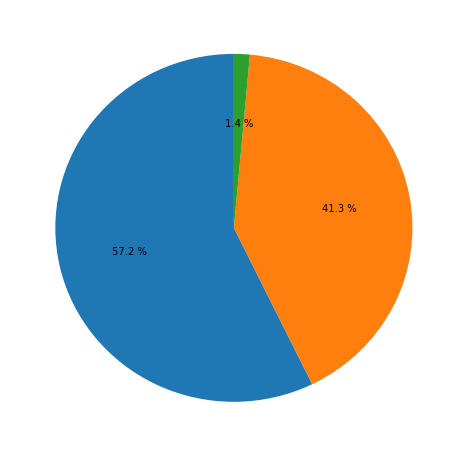

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [7]:
# lets explore the gender variable and see how are data is currently distibuted
plt.figure(figsize =(8, 8)) 
plt.pie(profile['gender'].value_counts(),
startangle = 90, autopct ='%.1f %%')
plt.show() 

profile['gender'].value_counts(ascending=False)

As our pie chart indicates, our male population make up to 57.2% of our data.. interesting, maybe we can suggust them offers on Movember ? mind you this data isn't clean yet so, carrying on.

Text(0.5,1,'Customer Age Chart')

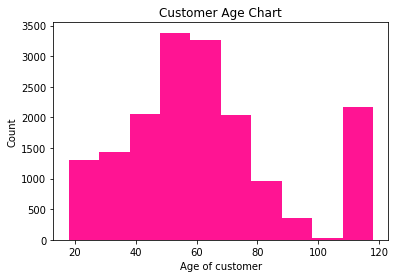

In [8]:
# next lets invistigate the age variable of the profile dataset
plt.hist(profile.age,color = '#FF1493' )
plt.xlabel('Age of customer')
plt.ylabel('Count')
plt.title('Customer Age Chart')

In [9]:
# ok? we have an outlier here.. cutomer age greater than 100? lets investigate further
profile.age.max()

118

Seems that our app allows for ages greater than a 100 to be added or they add 118 as a default value? either ways outliers need to be scurbbed off our data.

In [10]:
# we will look into income after we clean it up from the NaNs
# now lets evaluate our last dataset 
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [11]:
transcript.shape

(306534, 4)

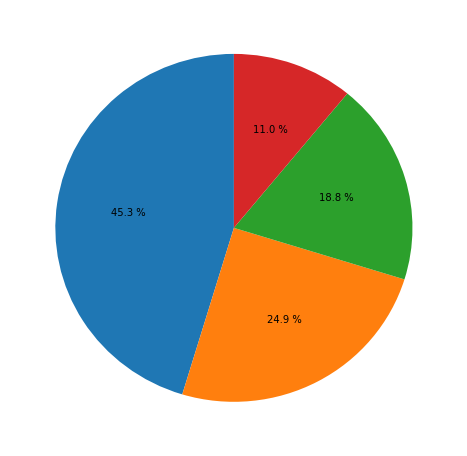

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [12]:
# lets explore the event variable and see how are data is currently distibuted
plt.figure(figsize =(8, 8)) 
plt.pie(transcript['event'].value_counts(),
startangle = 90, autopct ='%.1f %%')
plt.show() 

transcript['event'].value_counts(ascending=False)

Intersting! what we are observing here is 45.3% of the events are triggered bt a transaction and 24.9% have recieved the offer while, 18.8% have viewed the offer and the least at 11% have completed the offer. In the next steps we will find a correlation between this findings.

Now that we've seen our data we will move to the next step which is data cleaning.

## The Tidy Data plan (aka Data Cleaning)

In this step we will clean our data by taking necessary steps to standerize data, remove NaNs and get data ready to help us answer our business question.. 

In [13]:
# first off lets remove the outliers we saw in the Age variable of our profile set 
profile = profile[profile.age < 118].reset_index(drop=True)

In [14]:
#lets make sure there are no duplicates (Cause, we dont like copycats)
profile.duplicated().sum()

0

In [15]:
# Now lets make sure that the became_member_on_variable follows the correct time format
profile.became_member_on = pd.to_datetime(profile.became_member_on, format = '%Y%m%d')

In [16]:
# lets get dummy for thr gender variable of the profile dataset
profile = pd.concat([profile, pd.get_dummies(profile.gender).iloc[:,:-1]], axis = 1)
profile = profile.set_index('id')


Now that we finished tidying the profile variables lets clean the transcript dataset. As we saw in the previous step the value column had records looking like this:

{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}

How about we extract the id number and put it in a new column? 
and what are the values we need for analysis? 
we need the following to answer our business needs for the project:
1. Offer Received
2. Offer Viewed 
3. Offer Completed


In [17]:
# lets get started~
# first let create the new cokumn and assign it a Not applicable value denoted by NA

transcript['offer_id'] = "N/A"

In [18]:
# now lets store offers in seperate arrays
received_viewed = transcript[transcript.event.isin(['offer received', 'offer viewed'])]
completed =  transcript[transcript.event.isin(['offer completed'])]
transaction = transcript[transcript.event.isin(['transaction'])]

In [19]:
received_viewed.loc[:, 'offer_id'] = received_viewed.loc[:, 'value'].apply(lambda x: x['offer id'])
received_viewed.loc[:, 'value'] = 0
completed.loc[:, 'offer_id'] = completed.loc[:, 'value'].apply(lambda x: x['offer_id'])
completed.loc[:, 'value'] = 0
transaction.loc[:, 'value'] = transaction.loc[:, 'value'].apply(lambda x: x['amount'])

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [20]:
transcript = pd.concat([received_viewed, completed, transaction ])
transcript.sort_index(inplace=True)

In [21]:
# now lets see how our transcript dataframe looks like
transcript.shape

(306534, 5)

In [22]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 5 columns):
event       306534 non-null object
person      306534 non-null object
time        306534 non-null int64
value       306534 non-null float64
offer_id    306534 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 14.0+ MB


In [23]:
# Ok so far so good! but we're not yet done with the cleaning process
# now what we have to do for analysis is to find a way to combine the datasets for analysis

port_id = portfolio.id.values
profile_id = profile.index.values
combine_profile_transaction = pd.DataFrame(np.nan, index = profile_id, columns = port_id)

# allright now that we have our data in one place, next 
#we will create another table with three new columns describing:
# 1- Transaction triggered by an  offer
# 2- Number of transactions happening
# 3- The total of transactions

col = ['transactions_offers', 'transaction_num', 'total']
new_df = pd.DataFrame(np.zeros((profile.shape[0], 3)), index = profile_id, columns = col)

# now lets concat the two dataframes

combine_profile_transaction = pd.concat([combine_profile_transaction, new_df], axis = 1)

In [24]:
# Now lets create a function that gets the transactions per person given an id

def transactions(cid):
    '''
    input: a string value denoting customer id from profile dataframe
    
    output: a dataframe containing a transaction record per id given
    
    '''
    df = transcript[transcript.person == cid].reset_index(drop= True)
    return df
    

In [25]:
# lets get data for the BOGO or discound offer the plan is:
# flag true if the offer is received or viewed and completed
# flag false if the offer is received or viewed  and aren't completed



In [26]:
discount_offers_id = portfolio[portfolio.offer_type.isin(['bogo', 'discount'])].id.values
cnt = 0
progbar = progressbar.ProgressBar(maxval = combine_profile_transaction.shape[0], widgets = [progressbar.Bar('=', '[', ']'), progressbar.Percentage()] )
# now lets start the progress bar 
# why do we need a progress bar? Simple, a progress bar shows us the progress of the funtion's execution
# gives us an estimate to where in the code we need to look when error handling
#anyways carrying on..

progbar.start()

# cool now since we got the progress bar running lets loop through the customers profile
for i in range(profile.shape[0]):
    cnt += 1
    progbar.update(cnt)
    # now we get the customer id based on the function defined earlier
    i = combine_profile_transaction.index[i]
    get_tran = transactions(i)
    # now lets get the number of times offer completed and viewed
    times_completed = defaultdict(int)
    times_viewed = defaultdict(int)
    # now lets save received offers in an index
    rec_offer = get_tran[get_tran.event == 'offer received'].index.values
    #now lets save details regarding transaction
    trans_event = get_tran[get_tran.event == 'transaction']
    combine_profile_transaction.loc[i, 'transaction_num'] = trans_event.shape[0]
    combine_profile_transaction.loc[i, 'total'] = trans_event.value.sum()
    # now lets get offer data
    oindex = []
    for x in rec_offer:
        #get offer id
        oid = get_tran.loc[x, 'offer_id']
        #get offer duration
        oduriation =int(portfolio[portfolio.id == oid].duration) * 24
        time_start = get_tran.loc[x, 'time']
        end_time = time_start + oduriation
        get_rows = get_tran[(get_tran.offer_id == oid) 
                            & (get_tran.event == 'offer viewed')
                            & (get_tran.time >= time_start)
                            & (get_tran.time <= end_time)
                            ]
        if get_rows.shape[0] < 1:
            continue
        else: 
            if oid in discount_offers_id:
                rows = get_tran[(get_tran.offer_id == oid) & (get_tran.event == 'offer completed')
                                & (get_tran.time >= time_start) & (get_tran.time <= end_time)]
                if rows.shape[0] < 1:
                    times_completed[oid] += 0
                    times_viewed[oid] += 1
                else:
                    viewed_index = get_rows.index[0]
                    completed_index = rows.index[0]
                    
                    if viewed_index < completed_index:
                        times_completed[oid] += 1
                        times_viewed[oid] += 1 
                        oindex.extend(trans_event.loc[viewed_index:completed_index].index.values)
                    else: 
                        continue 
            else:
                times_v = get_rows.iloc[0].time
                times_viewed[oid] += 1
                info = get_tran[(get_tran.time >= times_v) & (get_tran.time <= end_time) & (get_tran.event == 'transaction')]
                
                if info.shape[0] > 0:
                    times_completed[oid] += 1
                else:
                    times_completed[oid] += 0
    for inx in times_viewed.keys():
        combine_profile_transaction.loc[i,inx] = round(times_completed[inx]/ times_viewed[inx], 2)
    if len(oindex) > 0:
        combine_profile_transaction.loc[i,'transactions_offers'] = trans_event.loc[list(set(oindex))].value.sum()
            
progbar.finish()
combine_profile_transaction.to_csv('combine_profile_transaction.csv')
            

[=========================================================================]100%


In [27]:
# store clean combined data in a new CSV to read it later
combine_profile_transaction = pd.read_csv('combine_profile_transaction.csv', index_col = 'Unnamed: 0')

In [28]:
# Now lets add a new column to count the average of transactions and the rate of transactions triggered by an offer
# t_average = Total/ (transaction_num + 0.001)
# offer_trigger_rate = transactions_offers / (total + 0.001)
combine_profile_transaction['t_average'] = round(combine_profile_transaction['total']/(combine_profile_transaction['transaction_num']+0.001), 2)
combine_profile_transaction['offer_trigger_rate'] = round(combine_profile_transaction['transactions_offers']/ (combine_profile_transaction['total']+0.001),2)

# lets combine the two tables[ takes a transaction with an offer and profile] 
combine_profile_transaction = pd.concat([profile.loc[:, ['age', 'income', 'gender', 'F', 'M']], combine_profile_transaction], axis=1) 

Text(0.5,1,'Transaction Total Distribution')

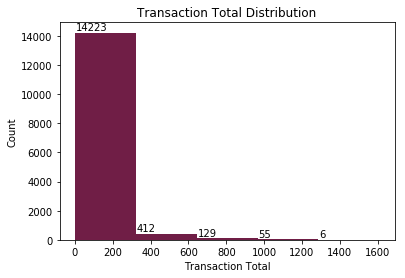

In [29]:
# now lets visulize our data to insure that our data has been clean
histo = plt.hist(combine_profile_transaction.total, bins= 5)
plt.hist(combine_profile_transaction.total, bins= 5, color = '#701e46')
for i in range(5):
    plt.text(histo[1][i]+5, histo[0][i]+150, int(histo[0][i]))
plt.xlabel('Transaction Total')
plt.ylabel('Count')
plt.title('Transaction Total Distribution')

Text(0.5,1,'Transaction Average Distribution')

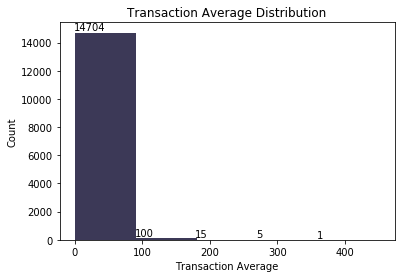

In [30]:
histo = plt.hist(combine_profile_transaction.t_average, bins= 5)
plt.hist(combine_profile_transaction.t_average, bins= 5, color = '#3c3957')
for i in range(5):
    plt.text(histo[1][i]-2, histo[0][i]+150, int(histo[0][i]))
plt.xlabel('Transaction Average')
plt.ylabel('Count')
plt.title('Transaction Average Distribution')

Our data seems to still need further cleaning before we take it for training and testing. As we can see some outlier present in the total and average of transactions.


In [31]:
t1, t2 = np.percentile(combine_profile_transaction.total, 75), np.percentile(combine_profile_transaction.total, 25)
a1, a2 = np.percentile(combine_profile_transaction.t_average, 75), np.percentile(combine_profile_transaction.t_average, 25)
total_ = t1 + 1.5 * (t1 - t2)
avgrage_ = a1 + 1.5 * (a1 - a2)

In [32]:
combine_profile_transaction = combine_profile_transaction[(combine_profile_transaction.total <= total_) & (combine_profile_transaction.t_average <= avgrage_)]
combine_profile_transaction.shape

(14349, 20)

Text(0.5,1,'Offer triggered rate for "Males"')

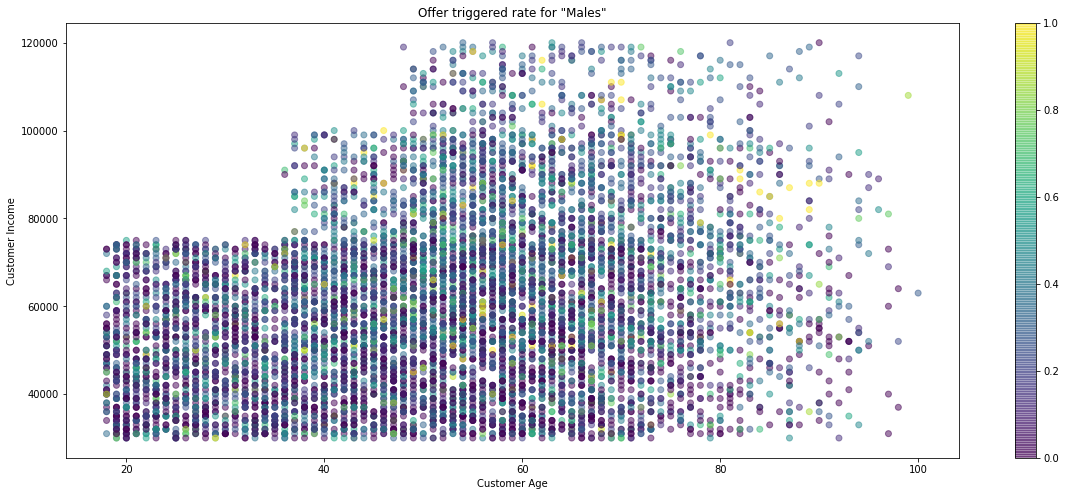

In [33]:
# lets visulize 
plt.figure(figsize=(20,8))
plt.scatter('age', 'income', c='offer_trigger_rate', cmap = 'viridis', alpha=0.5, data = combine_profile_transaction[combine_profile_transaction.gender=='M'])
plt.colorbar()
plt.xlabel('Customer Age')
plt.ylabel('Customer Income')
plt.title('Offer triggered rate for "Males"')


Text(0.5,1,'Offer triggered rate for "Females"')

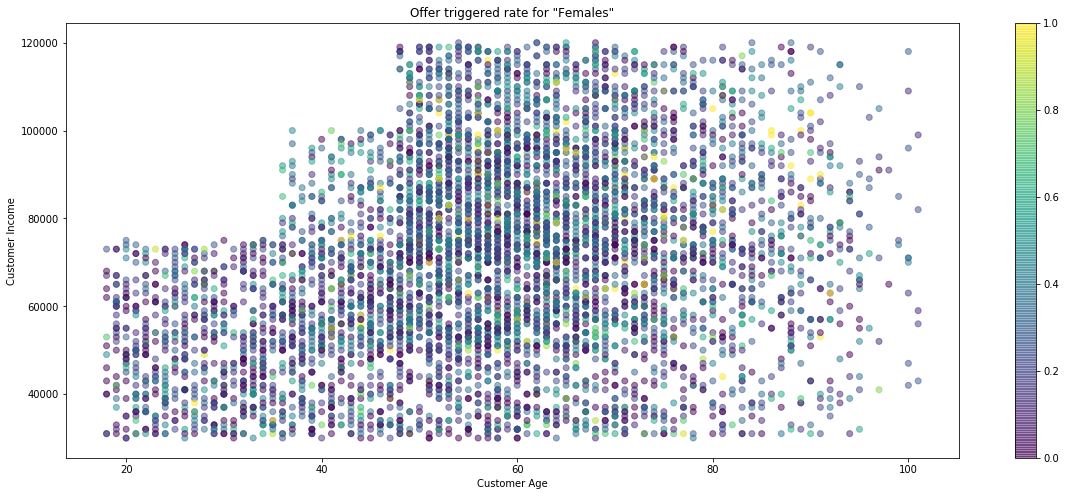

In [34]:
# lets visulize
plt.figure(figsize=(20,8))
plt.scatter('age', 'income', c='offer_trigger_rate', cmap = 'viridis', alpha=0.5, data = combine_profile_transaction[combine_profile_transaction.gender=='F'])
plt.colorbar()
plt.xlabel('Customer Age')
plt.ylabel('Customer Income')
plt.title('Offer triggered rate for "Females"')


#### Conclusion:
Based on our visulizations above we can conclude the following:
1. Age groupes between 40-60 seem to have the most transactions triggered by offers 
2. We can see linearity between income and age 
3. Males tend to make more offer triggered transactions than females
4. Surprisingly, youger males seem to be make more offer triggered transactions than older males while the opposite is true for females
5. We can see in both genders that the lower your income is the most likelihood they'd use an offer.

### Creating and Evaluating our model 
In this section we will create training and testings sets then create our model and then evaulate it.
We will use our model to try to predict a customers intention to use an offer or not. 

For prediction we will use an ensemble classifier (Random Forest algorithm) and two regression models. 
True, i tend to have a prefrence for using Random Forest Algorithm but can you blame me? i selected it for the following reasons:
1. It is shows high accuracy among learning algorithms available.
2. Estimates are unbiased.
3. Good for balancing errors in unbalanced datasets.
4. Has the capabilities to process unlabeled data effectively.
5. Though can overfit but has a less likelihood comparing it to other "tree based" algorithms
6. comes with a regression model too 

As for our regression models we will use:

1. Linear regression 
2. ForestRegressor

We will start with building the regression models to view scoring then we will build our classification model.

Now lets start building our model.

In [35]:
# lets define a function for regression models 
# i will start with building a function that returns a gridsearch dataframe of the RandomForestRegressor

def forestreg(X,Y):
    '''
    input: X, Y training data
    returns: dataframe of gridsearch 
    '''
    model = RandomForestRegressor()
    
    parameters= {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 7, 10, None],
        'min_samples_split': [2, 5, 7, 10] 
    }
    
    score = {'R2': 'r2', 'EV': 'explained_variance'}
    gridsearch = GridSearchCV(model, parameters, scoring = score, refit = 'R2', cv=5, return_train_score=False)
    gridsearch.fit(X,Y)
    
    return gridsearch
    
    

In [36]:
# lets define a function for linear regression
# Input: X, Y training Data
# Return: GridSearch DataFrame

def linearreg(X,Y):
    
    model = LinearRegression()
    
    parameters = {'fit_intercept':[True,False],
                  'normalize':[True,False], 
                  'copy_X':[True, False]
                 }
    score = {'R2': 'r2', 'EV': 'explained_variance'}
    
    gridsearch = GridSearchCV(model,parameters,scoring = score, refit = 'R2', return_train_score=False)
    gridsearch.fit(X,Y)
    
    return gridsearch
    
    

In [37]:
# now lets define the colums we need to take slices from for analysis
#define X, Y training sets 
# Store model

regr = []
con = combine_profile_transaction.loc[:,['age', 'income', 'F', 'M', 't_average', 'offer_trigger_rate']]

#lets start the progressbar

cnt = 0 
progbar = progressbar.ProgressBar(maxval=2, widgets=[progressbar.Bar('=', '[', ']'), progressbar.Percentage()])
progbar.start()

for i in range(2):
    cnt += 1
    progbar.update(cnt)
    
    X = con.iloc[:, :4]
    Y = con.iloc[:, 4+i]
    
    foreg = forestreg(X, Y)
    joblib.dump(foreg, 'r_'+str(i+1)+'.model')
    regr.append(foreg)
    
    results = pd.DataFrame(foreg.cv_results_)
    results.to_csv('r_'+str(i+1)+'.csv')
    
    progbar.finish()

[=========================================================================]100%


In [38]:
# now lets load the model created

regr = []
for i in range(2):
    file = 'r_' + str(i)
    locals()[file] = joblib.load('r_'+str(i+1)+'.model')
    regr.append(locals()[file])

In [39]:
#now lets define a function to decode values

def conv_values(age, income, gender):
    gender_list= {
         'F': [1, 0],
         'M': [0, 1],
         'O': [0, 0]}
    per = [age, income]
    per.extend(gender_list[gender])
    info = np.array(per).reshape(1,-1)
    return info

In [40]:
# lets buid a function that can predict the average given regression model and customer information
def predect_average(age, income, gender, model):
    regr = model
    info = conv_values(age, income, gender)
    predected_ = []
    for i in range(2):
        prediction = round(regr[i].predict(info)[0], 2)
        predected_.append(prediction)

    return predected_

In [41]:
# lets build a function that finds the average and ration based on a customer id

def find_avrg_customer(cid):
    df = combine_profile_transaction
    if cid in df.index:
        avrg , r = df.loc[cid][-2:].values
        return [avrg, r]
    else: 
        print("Invalid Customer ID")

In [42]:
# now lets test prediction using the functions we defined above

# for male customer(age = 40, income= 80000, gender = M)
m_01 =predect_average(40, 80000, 'M', regr)

# for female customer(age = 30, income= 50000, gender = F)
f_01 = predect_average(30, 50000, 'F', regr)


In [43]:
print('average predicted for Male customer who is age = 40, income= 80000')
print(m_01)
print("average predtion for female customer(age = 30, income= 50000, gender = F")
print(f_01)

average predicted for Male customer who is age = 40, income= 80000
[19.149999999999999, 0.32000000000000001]
average predtion for female customer(age = 30, income= 50000, gender = F
[9.5800000000000001, 0.22]


In [44]:
# now lets used the other function defined using search customer id 
# we'll grab a customer id first from data frame
#combine_profile_transaction.sample(n=1)


,age,income,gender,F,M,ae264e3637204a6fb9bb56bc8210ddfd,4d5c57ea9a6940dd891ad53e9dbe8da0,3f207df678b143eea3cee63160fa8bed,9b98b8c7a33c4b65b9aebfe6a799e6d9,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,fafdcd668e3743c1bb461111dcafc2a4,5a8bc65990b245e5a138643cd4eb9837,f19421c1d4aa40978ebb69ca19b0e20d,2906b810c7d4411798c6938adc9daaa5,transactions_offers,transaction_num,total,t_average,offer_trigger_rate
id,,,,,,,,,,,,,,,,,,,,
7b53d7ddc0d64a929d216857837bdab6,70,95000.0,F,1,0,NaN,1.0,1.0,NaN,1.0,1.0,NaN,0.0,NaN,1.0,110.63,12.0,288.15,24.01,0.38


In [45]:
# now lets search for an invalid customer
find_avrg_customer('xyz56575')

Invalid Customer ID


In [46]:
#now lets search using a valid customer id 
#lets select d7dd26d7142d4e51b63770cf9db2f91f
find_avrg_customer('d7dd26d7142d4e51b63770cf9db2f91f')

[19.010000000000002, 0.39000000000000001]

In [47]:
# now lets try with other regression model (linear regression)
lin = []
con2 = combine_profile_transaction.loc[:,['age', 'income', 'F', 'M', 't_average', 'offer_trigger_rate']]

#lets start the progressbar

cnt = 0 
progbar = progressbar.ProgressBar(maxval=2, widgets=[progressbar.Bar('=', '[', ']'), progressbar.Percentage()])
progbar.start()

for i in range(2):
    cnt += 1
    progbar.update(cnt)
    
    X = con2.iloc[:, :4]
    Y = con2.iloc[:, 4+i]
    
    linear = linearreg(X, Y)
    joblib.dump(linear, 'r_'+str(i+1)+'.model')
    lin.append(linear)
    
    results2 = pd.DataFrame(linear.cv_results_)
    results2.to_csv('r_'+str(i+1)+'.csv')
    
    progbar.finish()

[=========================================================================]100%


In [48]:
line = []
for i in range(2):
    file2 = 'r_' + str(i)
    locals()[file2] = joblib.load('r_'+str(i+1)+'.model')
    line.append(locals()[file2])

In [49]:
# lets see same prediction dataset on linear regression model
# for male customer(age = 40, income= 80000, gender = M)
m_02 =predect_average(40, 80000, 'M', line)

# for female customer(age = 30, income= 50000, gender = F)
f_02 = predect_average(30, 50000, 'F', line)

In [50]:
print('average predicted for Male customer who is age = 40, income= 80000')
print(m_02)
print("average predtion for female customer(age = 30, income= 50000, gender = F")
print(f_02)

average predicted for Male customer who is age = 40, income= 80000
[15.960000000000001, 0.26000000000000001]
average predtion for female customer(age = 30, income= 50000, gender = F
[9.0899999999999999, 0.23999999999999999]


In [51]:
# now since we finished with our regression model lets predict our data using Random Forest Classifier
# for our model we will create the training sets for our classifier
# we take values based on customer intention to use offers
# we will divide our training data from a range of numbers between 0 and 1
# (1) meaning that the customer has full intention to make a transaction triggered by an offer
# (0) meaning that the customer has no intention to make a transaction triggered by an offer
# lets start by building a function
# Takes a given column as an input
# Returns the trained X, Y values

def clf_randomforest(col):
    df = combine_profile_transaction
    data = df[(df.loc[:,col] == 1) | (df.loc[:,col] == 0)].loc[:, ['age','income','F','M',col]]
    X, Y = data.iloc[:,:4], data.iloc[:,-1]
    return X, Y

In [52]:
#lets define a function that builds our classifier and returns the grid search
def clf_gs(X, Y):
    clf = RandomForestClassifier()
    parameters = {'n_estimators': [50, 100, 200],
                  'criterion': ['gini', 'entropy'],
                  'max_depth': [5, 7, 10, 15, None],
                  'min_samples_split': [2, 3, 5, 7]
                 }
    score = {'Precision': 'precision', 'Recall': 'recall', 'F1': 'f1'}
    
    gs = GridSearchCV(clf, parameters, scoring = score, refit = 'F1', cv=5, return_train_score=False)
    gs.fit(X, Y)
    
    return gs

In [53]:
# Lets build the model by selecting a slice of the dataframe and give it for building our model
classifier = []
f1_score = []
list_offers = combine_profile_transaction.columns[5:17]
cnt = 0 
progbar2 = progressbar.ProgressBar(maxval=len(list_offers), widgets=[progressbar.Bar('=', '[', ']'), progressbar.Percentage()])
progbar2.start()

for i , x in enumerate(list_offers):
    cnt += 1
    progbar2.update(cnt)
    X, Y = clf_randomforest(x)
    gs = clf_gs(X, Y)
    joblib.dump(gs, 'clf_'+str(i+1)+'.model')
    classifier.append(gs)
    r = pd.DataFrame(gs.cv_results_)
    r.to_csv('clf_'+str(i+1)+'.csv')
    f1 = round(int(r[r.rank_test_F1 == 1]['mean_test_F1'].values[0]*100000)/1000,2)
    f1_score.append(f1)

progbar2.finish()

[=========================================================================]100%


In [54]:
# lets load built model
clf = []
for i in range(12):
    file_ = 'clf_' + str(i)
    locals()[file_] = joblib.load('clf_'+str(i+1)+'.model')
    clf.append(locals()[file_])
    rslt = pd.read_csv('clf_'+str(i+1)+'.csv')
    f1_ = round(int(rslt[rslt.rank_test_F1 == 1]['mean_test_F1'].values[0]*100000)/1000,2)
    f1_score.append(f1_)
                

In [55]:
print('Our F1 score for the RandomForest Classifier is: ')
f1_score

Our F1 score for the RandomForest Classifier is: 


[66.47,
 65.95,
 74.72,
 82.06,
 79.41,
 83.89,
 84.91,
 73.54,
 72.3,
 82.08,
 0.0,
 47.51,
 66.47,
 65.95,
 74.72,
 82.06,
 79.41,
 83.89,
 84.91,
 73.54,
 72.3,
 82.08,
 0.0,
 47.51]

Seeing on how good our F1, and RSquare scores are, our model has the capability to make predictions lets proceed by using our classifier to predict top N and then we will apply our model's capability of making preditions for what offer suits what customer lets get started. in the final step model evaluatiob

### Model Evaluation

This is the final step of our data journey (mhmm.. besides interpreting results and conclusions) anyways, we will evaluate our models by the following:
1. Its ability predict a N number of offer predictions given the age, income, gender of the customer
2. Its ability to predict the top N offers given a customer id
3. Its ability to see the top offers per transactions

We will use the powers of both the classfier and regression models to help us predict

Lets start

In [56]:
# Seeing our model evaluation plan lets start building our functions 
# The purpose of this function is to predict the top N offers given a customer characteristic
# This function takes the customers (Age, Income, gender), a number of offers we'd want to predict and the classifier
# for this project our classifier is Random forest
# This function returns the top N offers

def predict_n_info(age, income, gender, n, classifier):
    clf = classifier
    info = conv_values(age, income, gender)
    predict_list = []
    
    if (n == 0 | n < 0):
        print('Please enter a valid number')
    
    else: 
        for i in range(10):
            probability = clf[i].predict_proba(info)[0][1]
            predict_list.append(probability)
        offer =  pd.Series(predict_list, index=portfolio.id)
        sort_offer = offer.sort_values(ascending=False)
    top = sort_offer.index.values[:n]
    return top
    

In [57]:
# lets test our function by seeing the top 5 customers who are 25, income is 40000 and are M

top5 = predict_n_info(25, 40000, 'M', 5, classifier)

In [58]:
print("our top 5 offers ID for the given are: ")
top5

our top 5 offers ID for the given are: 


array(['3f207df678b143eea3cee63160fa8bed',
       '5a8bc65990b245e5a138643cd4eb9837',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '9b98b8c7a33c4b65b9aebfe6a799e6d9',
       'fafdcd668e3743c1bb461111dcafc2a4'], dtype=object)

Great! our model could predict the top 5 customers, now lets build a function that takes a customer id and makes an N predition of offer for them. we can take this function and use it for further prediction. now on to the next step lets start~

In [59]:
# For testing wanted to make sure where the age, income, gender were located in the dataframe
#combine_profile_transaction.columns[0:3]

In [60]:
# Carrying on our prediction plan
# We will build a function that predicts N offers given a customer id
# Function takes a parameter of a customer id, number of offers we want to see and the model 
# function returns the top n offers based on given customer

def predict_n_offer(cid, n, classifier):
    df =combine_profile_transaction
    if (n == 0 | n < 0):
        print('Please enter a valid number')
    elif ( cid not in df.index ):
        print('Please enter a customer id')
    else: 
        for cid in df.index:
            a ,  i , g = df.loc[cid][0:3]
            top = predict_n_info(a,i,g,n, classifier)
            return top

In [61]:
# now lets a build a function the top N most most appropriate offers based on customer information transactions
# This function the customers (Age, Income, gender), n number of top N we want to retrive 
# function rerirns predected offers, their average/ scores
# This function returns RSquare and Variance for ForestRegressor

def offer_triggered_prediction(age, income, gender,n): 
    top = predict_n_info(age, income, gender,n, classifier)
    offer_pred = portfolio.set_index('id', drop=True).loc[top]
    results = predect_average(age, income, gender,  regr)
    return offer_pred, results 
    

In [62]:
# now lets a build a function the top N most most appropriate offers based on customer information transactions
# This function the customers (Age, Income, gender), n number of top N we want to retrive 
# function rerirns predected offers, their average/ scores
# This function returns RSquare and Variance for Linear Regression
def offer_triggered_prediction_linear(age, income, gender,n): 
    top = predict_n_info(age, income, gender,n, classifier)
    offer_pred = portfolio.set_index('id', drop=True).loc[top]
    results = predect_average(age, income, gender,  line)
    return offer_pred, results 

In [63]:
# now lets build a function the top N offers given a customer 

def offer_per_customer(cid, n):
    df =combine_profile_transaction
    if cid in df.index: 
        a,i, g = df.loc[cid][0:3]
        top = predict_n_info(a,i,g, n, classifier)
        offer_pred = portfolio.set_index('id', drop=True).loc[top]['offer_type']  
        results = predect_average(a, i, g, classifier)
        return offer_pred, results 
    else: 
        print("Customer id invalid, please try a different id")
        

In [64]:
# lets test our function 
off = offer_per_customer('897514ffebfe49999ffdcead112a5b01', 2)
off

(id
 5a8bc65990b245e5a138643cd4eb9837    informational
 2298d6c36e964ae4a3e7e9706d1fb8c2         discount
 Name: offer_type, dtype: object, [0.0, 0.0])

In [65]:
# lets now see the results 
# lets try for a Male customer, Age = 40, Income = 80000 and n =5 
offers_for_customer, prediction = offer_triggered_prediction(40, 80000, 'M',5)

In [66]:
print("Our top 5 customer offers are")
offers_for_customer

Our top 5 customer offers are


,channels,difficulty,duration,offer_type,reward
id,,,,,
fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10,10,discount,2
2298d6c36e964ae4a3e7e9706d1fb8c2,"[web, email, mobile, social]",7,7,discount,3
9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5
ae264e3637204a6fb9bb56bc8210ddfd,"[email, mobile, social]",10,7,bogo,10
2906b810c7d4411798c6938adc9daaa5,"[web, email, mobile]",10,7,discount,2


In [67]:
print("Our prediction Rate using RandomRegressor: ")
prediction

Our prediction Rate using RandomRegressor: 


[19.149999999999999, 0.32000000000000001]

In [68]:
# for linear regression 
offers_for_customer_lin, prediction_lin =offer_triggered_prediction_linear(40, 80000, 'M',5)

In [69]:
offers_for_customer_lin

,channels,difficulty,duration,offer_type,reward
id,,,,,
fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10,10,discount,2
2298d6c36e964ae4a3e7e9706d1fb8c2,"[web, email, mobile, social]",7,7,discount,3
9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5
ae264e3637204a6fb9bb56bc8210ddfd,"[email, mobile, social]",10,7,bogo,10
2906b810c7d4411798c6938adc9daaa5,"[web, email, mobile]",10,7,discount,2


In [70]:
prediction_lin

[15.960000000000001, 0.26000000000000001]

In [72]:
from functools import reduce
f1_avrg = reduce(lambda x, y: x + y, f1_score) / len(f1_score) 
print("The Average F1 Score of our classifier is: ", round(f1_avrg, 2))

The Average F1 Score of our classifier is:  67.74


Intersting we can conclude that our F1 score is (0.67) approximatly 0.7, which is a great level of predictibility.

## Conclusion:

For this project we took startbucks data and took it on a data science journey where we started by exploring the data and then cleaning the data, visulizing it then building a model for prediction and seeing the prediction. 

We choose two regression models Linear Regression and RandomForest's Forest regressor. ForestRegressor showed a higher R2 and Variance in comparing to Linear despite Linear regression results being approximatly close. 

As for our classification model, seeing the result it approximatly has an f1 Score of (0.67) approximatly 0.7 . which is good and showed great preditions for the customers.
For our top 5 offers customers showed a prefrence do discounts and BOGO as they were repeated.
As our prediction rate for Forest Regressor showed:R2:19.12, EV: 0.32
While for Linear Regression showed: R2: 15.96, EV: 0.26

### Future Recommendations: 
1. Adding time and duration to make seasonal predictions if we can add seasons from an other dataset
2. Predicting based on customer loyality and membership.
3. Our regression models could've used more features to enhance model
4. predict offers based on the average of customer transactions


### Awesome refrences that helped us through this project 
1. https://jakevdp.github.io/PythonDataScienceHandbook/04.02-simple-scatter-plots.html
2. https://seaborn.pydata.org/tutorial/axis_grids.html
3. https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d
4.  https://medium.com/@susmitha.gudapati/starbucks-capstone-challenge-7dd19432c481
5. https://towardsdatascience.com/starbucks-capstone-challenge-8f4075b7a1da
6. https://pro.arcgis.com/en/pro-app/arcpy/geoprocessing_and_python/understanding-the-progress-dialog-in-script-tools.htm
7. https://github.com/syuenloh
8. https://pro.arcgis.com/en/pro-app/arcpy/geoprocessing_and_python/controlling-the-progress-dialog-box.htm
9. https://towardsdatascience.com/why-random-forest-is-my-favorite-machine-learning-model-b97651fa3706
10.  https://towardsdatascience.com/interpreting-the-coefficients-of-linear-regression-cc31d4c6f235
11. https://github.com/adam-p
12. https://realpython.com/linear-regression-in-python/
13. https://www.kaggle.com/hadend/tuning-random-forest-parameters
14. https://github.com/ft9738962
15. https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/
16. https://thevaluable.dev/dry-principle-explained/
18. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
19. https://www.kaggle.com/krohitm/f1-score-of-97-using-random-forest
20. https://github.com/mtasende
21. https://stats.stackexchange.com/questions/125756/classification-score-for-random-forest
22. https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/
23. https://towardsdatascience.com/the-dummys-guide-to-creating-dummy-variables-f21faddb1d40
24. https://github.com/mspcvsp
25. https://www.kaggle.com/devghiles/step-by-step-solution-with-f1-score-as-a-metric
26. https://code.tutsplus.com/tutorials/3-key-software-principles-you-must-understand--net-25161
27.  https://github.com/aldisf
28. http://queirozf.com/entries/one-hot-encoding-a-feature-on-a-pandas-dataframe-an-example
29. https://stackoverflow.com/questions/31593201/how-are-iloc-ix-and-loc-different
30. https://github.com/joshuayeung
31. https://towardsdatascience.com/logistic-regression-model-tuning-with-scikit-learn-part-1-425142e01af5
32. https://developers.google.com/machine-learning/crash-course/training-and-test-sets/splitting-data
33. https://towardsdatascience.com/statistics-for-machine-learning-r-squared-explained-425ddfebf667
34. https://www.geeksforgeeks.org/python-merge-join-and-concatenate-dataframes-using-panda/
35. https://www.geeksforgeeks.org/python-pandas-series-duplicated/
36.https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html

Thank you :-)